# For the testing before going to submit

## Data preprocessing

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
train_df = pd.read_csv('train.csv', index_col = 'id')

In [21]:
cat_features = ['cut', 'color', 'clarity']
def convert_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')
convert_cat(train_df, cat_features)

In [4]:
# since there is no row where x = 0 or y = 0 and z is non-zero, so we just need to drop the rows which z = 0
print(train_df[train_df['z'] == 0].shape[0])
train_df = train_df.drop(train_df[(train_df['z'] == 0) | (train_df['z'] > 30)].index)
print(train_df.shape)

10
(193562, 10)


In [5]:
train_df = train_df.drop(train_df[(train_df['z'] <= 2) | (train_df['z'] >= 6) | (train_df['y'] >= 10)].index)
print(train_df.shape)

(193556, 10)


In [6]:
# If you testing h2o, please don't run this line

train_df['carat'] = np.sqrt(train_df['carat'])

In [7]:
train_df['diameter'] = round((train_df.x + train_df.y)/2, 2)
train_df['depth_adj'] = round((train_df.z/train_df.diameter)*100, 1)
train_df.drop('depth', axis = 1, inplace = True)
train_df['weight_cat'] = pd.cut(train_df['carat'],
                               bins=[0., 0.5, 1.5, np.inf],
                               labels=[3, 2, 1])

train_df

,carat,cut,color,clarity,table,x,y,z,price,diameter,depth_adj,weight_cat
id,,,,,,,,,,,,
0,1.232883,Premium,F,VS2,58.0,7.27,7.33,4.55,13619,7.30,62.3,2
1,1.424781,Very Good,J,SI2,58.0,8.06,8.12,5.05,13387,8.09,62.4,2
2,0.836660,Ideal,G,VS1,57.0,5.69,5.73,3.50,2772,5.71,61.3,2
3,0.565685,Ideal,G,VS1,56.0,4.38,4.41,2.71,666,4.39,61.7,2
4,1.303840,Premium,G,VS2,59.0,7.65,7.61,4.77,14453,7.63,62.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
193568,0.556776,Ideal,D,VVS2,56.0,4.35,4.39,2.67,1130,4.37,61.1,2
193569,0.836660,Premium,G,VVS2,58.0,5.75,5.77,3.47,2874,5.76,60.2,2
193570,0.854400,Very Good,F,SI1,57.0,5.72,5.75,3.62,3036,5.74,63.1,2


In [8]:
num_features = ['carat', 'depth_adj', 'table','x', 'y', 'z', 'diameter']
cat_features.append('weight_cat')
cat_features

['cut', 'color', 'clarity', 'weight_cat']

In [9]:
# train_df['esti_volume'] = round(train_df.z*train_df.y*train_df.x, 2)
# num_features.append('esti_volume')
# num_features

['carat', 'depth_adj', 'table', 'x', 'y', 'z', 'diameter', 'esti_volume']

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# change test_size to 0.6 if you wotk with model testing, 0.2 for optuna testing

spliting = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)
for use_index, leave_index in spliting.split(train_df, train_df['weight_cat']):
    stra_use_set = train_df.iloc[use_index]
    stra_leave_set = train_df.iloc[leave_index]

In [14]:
y = stra_use_set['price']
X = stra_use_set.drop('price', axis=1)

In [9]:
category_order = [['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], 
                  ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
                  ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'],
                  ['1', '2', '3']]

In [10]:
# preprocess pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
#from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


num_transformer = Pipeline(steps =[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories = category_order))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [13]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['carat', 'depth_adj', 'table', 'x', 'y', 'z',
                                  'diameter']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                                                              'H',
                                                                              'I',
                                                                              'J'],
                                                                             ['IF',
                                                                              'VVS1',
                                                                              'VVS2',
                                                                              'VS1',
                                                                              'VS2',
                                                                              'SI1',
                                                                              'SI2',
                                                                              'I1'],
                                                                             ['1',
                                                                              '2',
                                                                              '3']]))]),
                                 ['cut', 'color', 'clarity', 'weight_cat'])])

In [14]:
X = preprocessor.transform(X)
X.shape

(154844, 11)

## Model testing

In [10]:
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor

# def display_scores(scores):
#     print("Scores:", scores)
#     print("Mean:", scores.mean())
#     print("Standard deviation:", scores.std())
    
# forest_reg = RandomForestRegressor(random_state=1)


# forest_scores = cross_val_score(forest_reg, X, y,                          
#                              scoring="neg_mean_squared_error", cv=5)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)
train_df

,carat,cut,color,clarity,table,x,y,z,price,diameter,depth_adj,weight_cat,esti_volume
id,,,,,,,,,,,,,
0,1.232883,Premium,F,VS2,58.0,7.27,7.33,4.55,13619,7.30,62.3,2,242.47
1,1.424781,Very Good,J,SI2,58.0,8.06,8.12,5.05,13387,8.09,62.4,2,330.51
2,0.836660,Ideal,G,VS1,57.0,5.69,5.73,3.50,2772,5.71,61.3,2,114.11
3,0.565685,Ideal,G,VS1,56.0,4.38,4.41,2.71,666,4.39,61.7,2,52.35
4,1.303840,Premium,G,VS2,59.0,7.65,7.61,4.77,14453,7.63,62.5,2,277.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193568,0.556776,Ideal,D,VVS2,56.0,4.35,4.39,2.67,1130,4.37,61.1,2,50.99
193569,0.836660,Premium,G,VVS2,58.0,5.75,5.77,3.47,2874,5.76,60.2,2,115.13
193570,0.854400,Very Good,F,SI1,57.0,5.72,5.75,3.62,3036,5.74,63.1,2,119.06


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)
X_train.shape, X_val.shape

((54196, 11), (23228, 11))

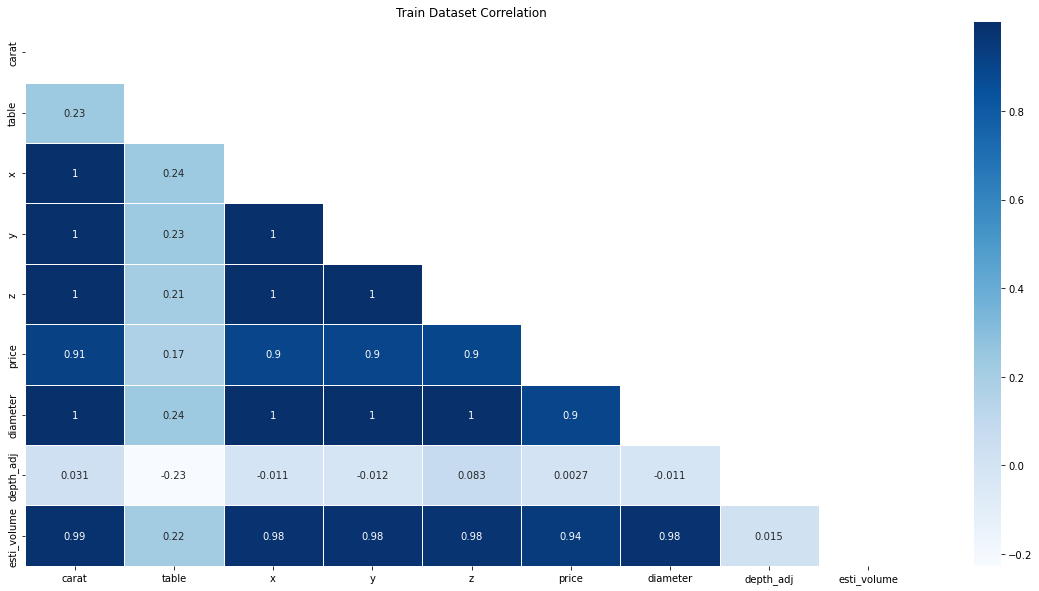

In [11]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# rf_reg = RandomForestRegressor(random_state = 21)
# rf_reg.fit(X_train, y_train)
# y_pred = rf_reg.predict(X_val)
# rf_mse = mean_squared_error(y_val, y_pred)
# rf_rmse = np.sqrt(rf_mse)
# rf_rmse
def plot_correlation_heatmap(df, title_name: str='Train correlation'):
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='Blues', annot=True)
    plt.title(title_name)
    plt.show()

#plot_correlation_heatmap(origin, 'Original Dataset Correlation')
plot_correlation_heatmap(train_df, 'Train Dataset Correlation')
#plot_correlation_heatmap(train, 'Test Dataset Correlation')

In [32]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(random_state = 21)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
xgb_mse = mean_squared_error(y_val, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

612.8088370857007

# Submission testing

In [143]:
X_final = train_df.drop('price', axis = 1)
y_final = train_df['price']
X_final.shape, y_final.shape

((193556, 12), (193556,))

In [144]:
test_df = pd.read_csv('test.csv', index_col = 'id')

In [145]:
# test_df['esti_volume'] = round(test_df.z*test_df.y*test_df.x, 2)

In [146]:
test_df['diameter'] = round((test_df.x + test_df.y)/2, 2)
test_df['depth_adj'] = round((test_df.z/test_df.diameter)*100, 1)

null_rows = test_df[test_df['depth_adj'].isnull()]
null_index = null_rows.index
test_df.loc[null_index, 'depth_adj'] = null_rows['depth']

test_df.drop('depth', axis = 1, inplace = True)

test_df['carat'] = np.sqrt(test_df['carat'])

test_df['weight_cat'] = pd.cut(test_df['carat'],
                               bins=[0., 0.5, 1.5, np.inf],
                               labels=[1, 2, 3])

convert_cat(test_df, cat_features)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129050 entries, 193573 to 322622
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   carat        129050 non-null  float64 
 1   cut          129050 non-null  category
 2   color        129050 non-null  category
 3   clarity      129050 non-null  category
 4   table        129050 non-null  float64 
 5   x            129050 non-null  float64 
 6   y            129050 non-null  float64 
 7   z            129050 non-null  float64 
 8   esti_volume  129050 non-null  float64 
 9   diameter     129050 non-null  float64 
 10  depth_adj    129050 non-null  float64 
 11  weight_cat   129050 non-null  category
dtypes: category(4), float64(8)
memory usage: 13.4 MB


In [147]:
preprocessor.fit(X_final)
X_final = preprocessor.transform(X_final)
X_test = preprocessor.transform(test_df)

In [148]:
from xgboost import XGBRegressor

best_params_xgb = {'tree_method': 'gpu_hist',
                   'reg_lambda': 2.553793950847241,
                   'colsample_bytree': 0.9,
                   'colsample_bylevel': 0.8,
                   'subsample': 0.9,
                   'learning_rate': 0.04480245593299995,
                   'n_estimators': 150,
                   'max_depth': 9,
                   'min_child_weight': 3,
                   'grow_policy': 'lossguide'}

model_reg1 = XGBRegressor(**best_params_xgb, random_state=21)
model_reg1.fit(X_final, y_final)
y_pred1 = model_reg1.predict(X_test)

df_prediction = pd.DataFrame({'id': test_df.index,
                       'price': y_pred1})
df_prediction

,id,price
0,193573,876.113281
1,193574,2461.066406
2,193575,2328.549072
3,193576,869.824341
4,193577,5830.035645
...,...,...
129045,322618,3834.853271
129046,322619,2611.011230
129047,322620,7546.550293
129048,322621,5632.525391


In [149]:
df_prediction.to_csv('test1.csv', index=False)

## h2o testing 

`h2o_pre2.csv` result by not taking sqrt(carat)

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [74]:
X_final = train_df.drop('price', axis = 1)
y_final = train_df['price']

preprocessor.fit(X_final)
X_final = preprocessor.transform(X_final)

In [75]:
y_final_reshaped = y_final.values.reshape(-1, 1)

combined_array = np.hstack((X_final, y_final_reshaped))

In [76]:
pre_col = list(num_features)
pre_col += cat_features
pre_col.append('price')

In [77]:
preproces_df = pd.DataFrame(combined_array, columns=pre_col)

In [78]:
preproces_df

,carat,depth_adj,table,x,y,z,diameter,cut,color,clarity,weight_cat,price
0,1.576937,0.444636,0.402574,1.401939,1.461007,1.482353,1.431587,3.0,2.0,4.0,2.0,13619.0
1,2.679538,0.536302,0.402574,2.114283,2.177890,2.212002,2.146311,2.0,6.0,6.0,2.0,13387.0
2,-0.195871,-0.472033,-0.118584,-0.022749,0.009094,-0.049908,-0.006907,4.0,3.0,3.0,1.0,2772.0
3,-1.017417,-0.105366,-0.639742,-1.203978,-1.188734,-1.202753,-1.201129,4.0,3.0,3.0,0.0,666.0
4,1.966090,0.627969,0.923732,1.744585,1.715092,1.803399,1.730143,3.0,3.0,4.0,2.0,14453.0
...,...,...,...,...,...,...,...,...,...,...,...,...
193551,-1.039036,-0.655367,-0.639742,-1.231029,-1.206883,-1.261125,-1.219224,4.0,0.0,2.0,0.0,1130.0
193552,-0.195871,-1.480368,0.402574,0.031353,0.045392,-0.093687,0.038328,3.0,3.0,2.0,1.0,2874.0
193553,-0.131012,1.177970,-0.118584,0.004302,0.027243,0.125207,0.020234,2.0,2.0,5.0,1.0,3036.0
193554,-0.974177,0.994637,-1.160900,-1.140859,-1.116138,-1.056823,-1.128752,2.0,0.0,5.0,0.0,681.0


In [79]:
h2o_frame = h2o.H2OFrame(preproces_df)
x = h2o_frame.columns
y = 'price'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [80]:
aml3 = H2OAutoML(sort_metric='rmse', max_runtime_secs=180, seed=1)
aml3.train(x=x, y=y, training_frame=h2o_frame)

AutoML progress: |█
21:37:13.564: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/13
# GBM base models (used / total),4/7
# DeepLearning base models (used / total),1/3
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [81]:
aml3.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_9_20230703_213713,571.901,327071,292.771,0.106635,327071
StackedEnsemble_AllModels_2_AutoML_9_20230703_213713,571.91,327081,292.769,0.106637,327081
StackedEnsemble_AllModels_1_AutoML_9_20230703_213713,572.222,327439,292.673,0.106392,327439
StackedEnsemble_BestOfFamily_3_AutoML_9_20230703_213713,572.576,327843,294.452,0.108022,327843
GBM_2_AutoML_9_20230703_213713,573.521,328926,294.05,0.107381,328926
StackedEnsemble_BestOfFamily_2_AutoML_9_20230703_213713,573.555,328965,294.197,0.107506,328965
GBM_3_AutoML_9_20230703_213713,574.254,329768,293.407,0.106332,329768
GBM_5_AutoML_9_20230703_213713,574.463,330007,296.112,0.109008,330007
GBM_1_AutoML_9_20230703_213713,575.862,331617,292.196,0.104697,331617
StackedEnsemble_BestOfFamily_1_AutoML_9_20230703_213713,575.967,331738,292.602,0.105054,331738


In [82]:
test_df = pd.read_csv('test.csv', index_col = 'id')

test_df['diameter'] = round((test_df.x + test_df.y)/2, 2)
test_df['depth_adj'] = round((test_df.z/test_df.diameter)*100, 1)

null_rows = test_df[test_df['depth_adj'].isnull()]
null_index = null_rows.index
test_df.loc[null_index, 'depth_adj'] = null_rows['depth']

test_df.drop('depth', axis = 1, inplace = True)

# test_df['carat'] = np.sqrt(test_df['carat'])

test_df['weight_cat'] = pd.cut(test_df['carat'],
                               bins=[0., 0.5, 1.5, np.inf],
                               labels=[1, 2, 3])
convert_cat(test_df, cat_features)

X_test = preprocessor.transform(test_df)

pre_col.remove('price')

preproces_test_df = pd.DataFrame(X_test, columns=pre_col)

In [83]:
test_frame = h2o.H2OFrame(preproces_test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [84]:
pred = aml3.predict(test_frame)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
875.012
2476.94
2328.37
834.542
5786.4
680.43
12402.5
2990.09
15258.6
1862.87


In [85]:
pred = pred.as_data_frame()
pred = pred.values
pred = pred.reshape(-1)

# test_h2o = test_h2o.as_data_frame()
# test_h2o.set_index('id', inplace=True)

In [86]:
df_prediction = pd.DataFrame({'id': test_df.index,
                       'price': pred})
df_prediction

,id,price
0,193573,875.012090
1,193574,2476.943738
2,193575,2328.368351
3,193576,834.542329
4,193577,5786.396569
...,...,...
129045,322618,3783.415807
129046,322619,2608.296078
129047,322620,7608.609007
129048,322621,5758.991942


In [87]:
df_prediction.to_csv('h2o_pre2.csv', index=False)

## Optuna testing

##### xgb

In [16]:
import optuna

In [17]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [44]:
X_final = train_df.drop('price', axis = 1)
y_final = train_df['price']

X_final = preprocessor.fit_transform(X_final)

In [45]:
pre_col = list(num_features)
pre_col += cat_features

X_final_df = pd.DataFrame(X_final, columns=pre_col)

In [53]:
def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': trial.suggest_categorical(
            'tree_method', ['gpu_hist']
        ),
        'reg_lambda': trial.suggest_float(
            'reg_lambda', 1e-3, 1e2, log=True
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 0.5, 1.0, step=0.1
        ),
        'colsample_bylevel': trial.suggest_float(
            'colsample_bylevel', 0.5, 1.0, step=0.1
        ),
        'subsample': trial.suggest_float(
            'subsample', 0.5, 1.0, step=0.1
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 1e-2, 1e0, log=True
        ),
        'n_estimators': trial.suggest_int(
            'n_estimators', 50, 200, step=10
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 3, 9, step=2
        ),
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 5, step=2
        ),
        'grow_policy': trial.suggest_categorical(
            'grow_policy', ['lossguide']
        )
    }
    kf = KFold(n_splits=5, random_state=21, shuffle=True)
    val_split_rmse = []
    for train_idx, val_idx in kf.split(X_final_df):
        X_train_split, X_val_split = X_final_df.iloc[train_idx], X_final_df.iloc[val_idx]
        Y_train_split, Y_val_split = y_final.iloc[train_idx], y_final.iloc[val_idx]
        estimator = XGBRegressor(**params)
        estimator.fit(X_train_split, Y_train_split, eval_set=[(X_val_split, Y_val_split)], early_stopping_rounds=5, verbose=0)
        Y_pred_val = pd.Series(estimator.predict(X_val_split), index=X_val_split.index)
        rmse = np.sqrt(mean_squared_error(Y_val_split, Y_pred_val))
        val_split_rmse.append(rmse)
        
    val_rmse = np.mean(val_split_rmse)
    return val_rmse

In [54]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=20, show_progress_bar=True)

[I 2023-07-04 00:26:43,761] A new study created in memory with name: no-name-60e172fe-8629-422a-93a6-783177cfe25b


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:27:19,243] Trial 0 finished with value: 808.7995633304754 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 1.0816629630626655, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.018961668449541107, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 1, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 808.7995633304754.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:27:22,318] Trial 1 finished with value: 700.0228649234853 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.03747697793494212, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.044212940814352876, 'n_estimators': 80, 'max_depth': 5, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 700.0228649234853.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:27:23,698] Trial 2 finished with value: 619.141609277013 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.0034708611187847516, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.9804545766204127, 'n_estimators': 70, 'max_depth': 3, 'min_child_weight': 1, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 619.141609277013.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:27:27,291] Trial 3 finished with value: 588.2054049779636 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 33.29431173172454, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.5343517396882866, 'n_estimators': 150, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:10,320] Trial 4 finished with value: 634.2047385320302 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.003911615538716871, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.023248354241521788, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:13,489] Trial 5 finished with value: 774.1765538763278 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 3.9469997555384424, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'learning_rate': 0.021753932951237367, 'n_estimators': 190, 'max_depth': 3, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:14,940] Trial 6 finished with value: 611.2238418853789 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.0033914413017361476, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.5309065349058831, 'n_estimators': 180, 'max_depth': 3, 'min_child_weight': 1, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:19,240] Trial 7 finished with value: 663.986615281858 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.748533899792722, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.026255682721542568, 'n_estimators': 120, 'max_depth': 5, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:21,408] Trial 8 finished with value: 1091.597154200763 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 22.40165737666807, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.018805992210367398, 'n_estimators': 120, 'max_depth': 3, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:24,745] Trial 9 finished with value: 2114.1436937762837 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 6.4257548483587685, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8, 'subsample': 0.7, 'learning_rate': 0.011829712918035713, 'n_estimators': 90, 'max_depth': 5, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 588.2054049779636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:30,552] Trial 10 finished with value: 580.2119225398241 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 95.7811309528612, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.22248567116240786, 'n_estimators': 170, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 580.2119225398241.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:36,011] Trial 11 finished with value: 578.6622125445845 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 92.3745877700611, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.24675171794411627, 'n_estimators': 170, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 578.6622125445845.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:46,837] Trial 12 finished with value: 575.4909149336636 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 71.53984591862229, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.11698325157758806, 'n_estimators': 170, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 575.4909149336636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:28:58,095] Trial 13 finished with value: 576.0515166968623 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 96.03474705579896, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'learning_rate': 0.11258682495260193, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 575.4909149336636.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:29:11,241] Trial 14 finished with value: 575.3211550029204 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 9.36329976983981, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'learning_rate': 0.07995388348771042, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 575.3211550029204.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:29:36,201] Trial 15 finished with value: 575.3631154784084 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 8.012256394540632, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.9, 'learning_rate': 0.0723186523964873, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 5, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 575.3211550029204.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:30:09,392] Trial 16 finished with value: 575.3283402489284 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 6.2583036848571405, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.9, 'learning_rate': 0.058151561418437, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 575.3211550029204.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:30:27,351] Trial 17 finished with value: 619.7962024780629 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.20729009567395812, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.9, 'learning_rate': 0.06573758215012508, 'n_estimators': 50, 'max_depth': 9, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 575.3211550029204.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:31:09,689] Trial 18 finished with value: 574.2992749020543 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 2.553793950847241, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'subsample': 0.9, 'learning_rate': 0.04480245593299995, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 3, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 574.2992749020543.


C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].
  warnings.warn(
C:\Anaconda\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 6] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 5].
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early

[I 2023-07-04 00:31:59,413] Trial 19 finished with value: 576.8180033238582 and parameters: {'tree_method': 'gpu_hist', 'reg_lambda': 0.923073618361629, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.9, 'learning_rate': 0.03810028406082724, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 1, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 574.2992749020543.


In [55]:
study.trials_dataframe().sort_values(by='value').head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bylevel,params_colsample_bytree,params_grow_policy,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_lambda,params_subsample,params_tree_method,state
18,18,574.299275,2023-07-04 00:30:27.355196,2023-07-04 00:31:09.689215,0 days 00:00:42.334019,0.8,0.9,lossguide,0.044802,9,3,150,2.553794,0.9,gpu_hist,COMPLETE
14,14,575.321155,2023-07-04 00:28:58.099870,2023-07-04 00:29:11.241893,0 days 00:00:13.142023,1.0,0.5,lossguide,0.079954,7,5,200,9.363300,0.9,gpu_hist,COMPLETE
16,16,575.328340,2023-07-04 00:29:36.205258,2023-07-04 00:30:09.392695,0 days 00:00:33.187437,0.7,0.8,lossguide,0.058152,9,3,200,6.258304,0.9,gpu_hist,COMPLETE
15,15,575.363115,2023-07-04 00:29:11.246894,2023-07-04 00:29:36.200257,0 days 00:00:24.953363,0.7,0.8,lossguide,0.072319,9,5,200,8.012256,0.9,gpu_hist,COMPLETE
12,12,575.490915,2023-07-04 00:28:36.016931,2023-07-04 00:28:46.837100,0 days 00:00:10.820169,1.0,0.5,lossguide,0.116983,7,5,170,71.539846,1.0,gpu_hist,COMPLETE


In [56]:
best_params_xgb = study.best_trial.params
best_params_xgb

{'tree_method': 'gpu_hist',
 'reg_lambda': 2.553793950847241,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.8,
 'subsample': 0.9,
 'learning_rate': 0.04480245593299995,
 'n_estimators': 150,
 'max_depth': 9,
 'min_child_weight': 3,
 'grow_policy': 'lossguide'}

##### GradientBoosting

In [34]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [35]:
X_final = train_df.drop('price', axis = 1)
y_final = train_df['price']

X_final = preprocessor.fit_transform(X_final)

In [36]:
pre_col = list(num_features)
pre_col += cat_features

X_final_df = pd.DataFrame(X_final, columns=pre_col)

In [40]:
def objective_gb(trial):
    params = {
        'max_iter': trial.suggest_int(
            'max_iter', 70, 180, step=10
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 1e-2, 1e0, log=True
        ),
        'l2_regularization': trial.suggest_float(
            'l2_regularization', 0.1, 1, step=0.1
        )
    }
    kf = KFold(n_splits=5, random_state=21, shuffle=True)
    val_split_rmse = []
    for train_idx, val_idx in kf.split(X_final_df):
        X_train_split, X_val_split = X_final_df.iloc[train_idx], X_final_df.iloc[val_idx]
        Y_train_split, Y_val_split = y_final.iloc[train_idx], y_final.iloc[val_idx]
        estimator = HistGradientBoostingRegressor(**params)
        estimator.fit(X_train_split, Y_train_split)
        Y_pred_val = pd.Series(estimator.predict(X_val_split), index=X_val_split.index)
        rmse = np.sqrt(mean_squared_error(Y_val_split, Y_pred_val))
        val_split_rmse.append(rmse)
        
    val_rmse = np.mean(val_split_rmse)
    return val_rmse

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_gb, n_trials=20, show_progress_bar=True)

[I 2023-07-04 01:14:41,640] A new study created in memory with name: no-name-f06dbb2b-efa3-45b4-9c16-2f4b346dc36e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-07-04 01:14:46,902] Trial 0 finished with value: 633.1552244119691 and parameters: {'max_iter': 70, 'learning_rate': 0.043774017350668465, 'l2_regularization': 0.2}. Best is trial 0 with value: 633.1552244119691.
[I 2023-07-04 01:14:52,107] Trial 1 finished with value: 579.3694068451466 and parameters: {'max_iter': 110, 'learning_rate': 0.17594614141662093, 'l2_regularization': 0.30000000000000004}. Best is trial 1 with value: 579.3694068451466.
[I 2023-07-04 01:15:04,170] Trial 2 finished with value: 662.3463395528112 and parameters: {'max_iter': 170, 'learning_rate': 0.01649228324777923, 'l2_regularization': 0.5}. Best is trial 1 with value: 579.3694068451466.
[I 2023-07-04 01:15:09,939] Trial 3 finished with value: 577.5627483886648 and parameters: {'max_iter': 80, 'learning_rate': 0.12876615995526922, 'l2_regularization': 0.8}. Best is trial 3 with value: 577.5627483886648.
[I 2023-07-04 01:15:16,802] Trial 4 finished with value: 577.4849473968254 and parameters: {'max_iter

In [42]:
study.trials_dataframe().sort_values(by='value').head()

,number,value,datetime_start,datetime_complete,duration,params_l2_regularization,params_learning_rate,params_max_iter,state
12,12,575.728418,2023-07-04 01:16:02.451768,2023-07-04 01:16:11.643064,0 days 00:00:09.191296,0.7,0.060053,130,COMPLETE
17,17,575.797098,2023-07-04 01:16:50.571452,2023-07-04 01:16:58.940431,0 days 00:00:08.368979,0.4,0.077336,180,COMPLETE
15,15,575.804502,2023-07-04 01:16:25.523051,2023-07-04 01:16:36.353620,0 days 00:00:10.830569,0.4,0.070229,140,COMPLETE
11,11,576.085742,2023-07-04 01:15:54.383318,2023-07-04 01:16:02.446766,0 days 00:00:08.063448,0.7,0.071337,110,COMPLETE
10,10,576.120767,2023-07-04 01:15:45.494316,2023-07-04 01:15:54.378316,0 days 00:00:08.884000,0.7,0.069128,110,COMPLETE


In [43]:
best_params_gb = study.best_trial.params
best_params_gb

{'max_iter': 130,
 'learning_rate': 0.060053375192846106,
 'l2_regularization': 0.7000000000000001}

In [44]:
# from sklearn.ensemble import RandomForestRegressor

In [46]:
# X_final = train_df.drop('price', axis = 1)
# y_final = train_df['price']

# X_final = preprocessor.fit_transform(X_final)

In [47]:
# pre_col = list(num_features)
# pre_col += cat_features

# X_final_df = pd.DataFrame(X_final, columns=pre_col)

In [53]:
# def objective_rf(trial):
#     params = {
#         'n_estimators': trial.suggest_int(
#             'n_estimators', 70, 180, step=10
#         ),
#         'max_features': trial.suggest_categorical(
#             'max_features', ['sqrt', None]
#         )
#     }
#     kf = KFold(n_splits=5, random_state=21, shuffle=True)
#     val_split_rmse = []
#     for train_idx, val_idx in kf.split(X_final_df):
#         X_train_split, X_val_split = X_final_df.iloc[train_idx], X_final_df.iloc[val_idx]
#         Y_train_split, Y_val_split = y_final.iloc[train_idx], y_final.iloc[val_idx]
#         estimator = RandomForestRegressor(**params)
#         estimator.fit(X_train_split, Y_train_split)
#         Y_pred_val = pd.Series(estimator.predict(X_val_split), index=X_val_split.index)
#         rmse = np.sqrt(mean_squared_error(Y_val_split, Y_pred_val))
#         val_split_rmse.append(rmse)
        
#     val_rmse = np.mean(val_split_rmse)
#     return val_rmse

In [15]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_rf, n_trials=20, show_progress_bar=True)

Too time-consuming for randomforest that we get rid of it